In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from scipy import special as sp
import scipy.integrate as integrate
from tqdm import tqdm
from scipy.constants import fine_structure, speed_of_light, electron_mass, elementary_charge, hbar, epsilon_0

In [3]:
#variáveis e constantes
electron_radius = elementary_charge**2/(4*pi*epsilon_0*electron_mass*speed_of_light**2)
num_pon = 100                                                      #número de pontos
mag_field = 7.48e6                                                 #[T] intensidade do campo magnético
tau_e = hbar/(speed_of_light**2*electron_mass)                     #[s] time it takes for light to travel across the electron radius electron_radius/speed_of_light
t_end = 2.2                                                        #tempos finais
t_steps = 5000                                                     #numero de steps
t_int = t_end/t_steps                                              #intervalo de tempo
min_ene = 0.0001                                                   #energia mínima
max_ene = 3600                                                     #energia máxima
d_ene = max_ene/num_pon                                            #intervalo de energia
ene_0 = 3000                                                       #energia inicial
ene_lst = np.linspace(min_ene, max_ene, num_pon)
time_lst = np.linspace(0, t_end, t_steps)
fdumps = np.zeros((t_steps,3*num_pon))

In [4]:
ene_lst_3 = np.zeros(3*num_pon)

for i in tqdm(range(num_pon)):
    ene_lst_3[i] = ene_lst[i]
    ene_lst_3[i + num_pon] = ene_lst[i]
    ene_lst_3[i + 2*num_pon] = ene_lst[i]


enelst_final_e = np.zeros(t_steps)
enelst_final_p = np.zeros(t_steps)
enelst_final_g = np.zeros(t_steps)
numlst_final_e = np.zeros(t_steps)
numlst_final_p = np.zeros(t_steps)
numlst_final_g = np.zeros(t_steps)
chilst_final_e = np.zeros(t_steps)
chilst_final_p = np.zeros(t_steps)
chilst_final_g = np.zeros(t_steps)

dfdt_mat = np.zeros((3*num_pon,3*num_pon))
dfdt_mat_11_i = np.zeros((3*num_pon,3*num_pon))
dfdt_mat_11_o = np.zeros((3*num_pon,3*num_pon))
dfdt_mat_13 = np.zeros((3*num_pon,3*num_pon))
dfdt_mat_22_i = np.zeros((3*num_pon,3*num_pon))
dfdt_mat_22_o = np.zeros((3*num_pon,3*num_pon))
dfdt_mat_23 = np.zeros((3*num_pon,3*num_pon))
dfdt_mat_31 = np.zeros((3*num_pon,3*num_pon))
dfdt_mat_32 = np.zeros((3*num_pon,3*num_pon))
dfdt_mat_33 = np.zeros((3*num_pon,3*num_pon))

100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<?, ?it/s]


In [5]:
def getEnergy(f):
    return np.trapz(f * ene_lst, ene_lst)

def getNumber(f):
    return np.trapz(f, ene_lst)

def getChi(f):
    return np.trapz(f * ene_lst, ene_lst) / (
                np.trapz(f, ene_lst) + 1e-12) * cnst_prop_2(mag_field)
                
def dfdt(yn):
    res = np.matmul(dfdt_mat, yn)
    return res

def cnst_prop_2(mag):
    return mag/(4.5*10**(9))

#equacao 3.83 de 'Classical and Quantum Description of Plasma and Radiation in Strong Fields' de Fabien Niel
def G_tilde_int(chi, epsilon):
    v = 2 * epsilon / (3 * chi * (1 - epsilon))
    return np.sqrt(3) / (2 * pi) * epsilon * (
                integrate.quad(lambda x: sp.kv(5 / 3, x), v, np.inf)[
                    0] + 1.5 * epsilon * chi * v * sp.kv(2 / 3, v))

G_tilde_int_vec_aux = lambda chi1, epsilon1: G_tilde_int(chi1, epsilon1)

G_tilde_int_vec = np.vectorize(G_tilde_int_vec_aux)

#equacao 3.82 de 'Classical and Quantum Description of Plasma and Radiation in Strong Fields' de Fabien Niel
def dN_dg(chi, epsilon):
    omega_c = elementary_charge / electron_mass/1800**2 * mag_field * max_ene
    if chi/cnst_prop_2(mag_field) <= min_ene or epsilon * chi/cnst_prop_2(mag_field) <= min_ene or epsilon >= 1 or epsilon <= 0:
        return 0
    return (2 / 3) * fine_structure / tau_e / omega_c * G_tilde_int_vec(chi, epsilon) / (epsilon * (chi/cnst_prop_2(mag_field))**2)

#equacao 3.92 de 'Classical and Quantum Description of Plasma and Radiation in Strong Fields' de Fabien Niel
def T_tilde(chi, epsilon):
    v_linha = 2/(3*chi*(1-epsilon))
    return np.sqrt(3)/(2*pi)*epsilon*(1.5*(chi/epsilon)*v_linha*sp.kv(2/3, v_linha) - integrate.quad(lambda x: sp.kv(5 / 3, x), v_linha, np.Inf)[0])

T_tilde_int_vec_aux = lambda chi1, epsilon1: G_tilde_int(chi1, epsilon1)

T_tilde_int_vec = np.vectorize(G_tilde_int_vec_aux)

#equacao 3.91 de 'Classical and Quantum Description of Plasma and Radiation in Strong Fields' de Fabien Niel
def dN_dl(chi, epsilon):
    omega_c = elementary_charge / electron_mass/1800**2 * mag_field * max_ene
    if (chi/epsilon)*cnst_prop_2(mag_field) <= min_ene or epsilon >= 1:
        return 0
    return (2 / 3) * fine_structure / tau_e / omega_c * T_tilde_int_vec(chi, epsilon) / ((chi/cnst_prop_2(mag_field))**2/epsilon)

# electron: outgoing
for i in tqdm(range(num_pon)):
    dfdt_mat_11_o[i, i] = -np.sum(
        np.array([dN_dg(ene_lst[i] * cnst_prop_2(mag_field), g/ene_lst[i]) for g in ene_lst[ene_lst < ene_lst[i]]])) * d_ene

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\jmcm2\AppData\Local\Temp\ipykernel_25176\4011042410.py:22: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrate.quad(lambda x: sp.kv(5 / 3, x), v, np.inf)[
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.31it/s]


In [6]:
# electron: outgoing
for i in tqdm(range(num_pon)):
    dfdt_mat_11_o[i, i] = -np.sum(
        np.array([dN_dg(ene_lst[i] * cnst_prop_2(mag_field), g/ene_lst[i]) for g in ene_lst[ene_lst < ene_lst[i]]])) * d_ene

# electron: ingoing
for i in tqdm(range(num_pon)):
    for j in range(i, num_pon):
        dfdt_mat_11_i[i, j] = dN_dg(ene_lst[j]*cnst_prop_2(mag_field), (ene_lst[j] - ene_lst[i])/ene_lst[j]) * d_ene

# electron: pair production
for i in tqdm(range(num_pon)):
    for j in range(i, num_pon):
        dfdt_mat_13[i, 2 * num_pon + j] = dN_dl(ene_lst[i]*cnst_prop_2(mag_field), ene_lst[i]/ene_lst[j]) * d_ene

# positron: outgoing
for i in tqdm(range(num_pon)):
    dfdt_mat_22_o[num_pon + i, num_pon + i] = -np.sum(
        np.array([dN_dg(ene_lst[i] * cnst_prop_2(mag_field), g/ene_lst[i]) for g in ene_lst[ene_lst < ene_lst[i]]])) * d_ene

# positron: ingoing
for i in tqdm(range(num_pon)):
    for j in range(i, num_pon):
        dfdt_mat_22_i[num_pon + i, num_pon + j] = dN_dg(ene_lst[j]*cnst_prop_2(mag_field), (ene_lst[j] - ene_lst[i])/ene_lst[j]) * d_ene

# positron: pair production
for i in tqdm(range(num_pon)):
    for j in range(i, num_pon):
        dfdt_mat_23[num_pon + i, 2 * num_pon + j] = dN_dl(ene_lst[i]*cnst_prop_2(mag_field), ene_lst[i]/ene_lst[j]) * d_ene

# photon: photon production from leptons
for i in tqdm(range(num_pon)):
    for j in range(i, num_pon):
        # electrons
        dfdt_mat_31[2 * num_pon + i, 0 * num_pon + j] = dN_dg(ene_lst[j]*cnst_prop_2(mag_field),
                                                         ene_lst[i]/ene_lst[j]) * d_ene
        # positrons
        dfdt_mat_32[2 * num_pon + i, 1 * num_pon + j] = dN_dg(ene_lst[j]*cnst_prop_2(mag_field),
                                                         ene_lst[i]/ene_lst[j]) * d_ene
# photon: photon decay
for i in tqdm(range(num_pon)):
    dfdt_mat_33[2 * num_pon + i, 2 * num_pon + i] = -np.sum(np.array(
        [dN_dl(g * cnst_prop_2(mag_field), g/ene_lst[i]) for g in
         ene_lst[(ene_lst < ene_lst[i]) + (ene_lst >= 2)]])) * d_ene

dfdt_mat = dfdt_mat_11_i + dfdt_mat_11_o + dfdt_mat_13 + dfdt_mat_22_i + dfdt_mat_22_o + dfdt_mat_23 + dfdt_mat_31 + dfdt_mat_32 + dfdt_mat_33

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\jmcm2\AppData\Local\Temp\ipykernel_25176\4011042410.py:22: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrate.quad(lambda x: sp.kv(5 / 3, x), v, np.inf)[
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 56.88it/s]


In [7]:
yn = np.zeros(3*num_pon)

yn[np.abs(ene_lst-ene_0).argmin()] = 1

fdumps[0,:] = yn
enelst_final_e[0] = getEnergy(yn[:num_pon])
enelst_final_p[0] = getEnergy(yn[num_pon:2*num_pon])
enelst_final_g[0] = getEnergy(yn[2*num_pon:3*num_pon])
numlst_final_e[0] = getNumber(yn[:num_pon])
numlst_final_p[0] = getNumber(yn[num_pon:2*num_pon])
numlst_final_g[0] = getNumber(yn[2*num_pon:3*num_pon])
chilst_final_e[0] = getChi(yn[:num_pon])
chilst_final_p[0] = getChi(yn[num_pon:2*num_pon])
chilst_final_g[0] = getChi(yn[2*num_pon:3*num_pon])

for n in tqdm(range(1, t_steps)):
    k1 = dfdt(yn)
    k2 = dfdt(yn+t_int*k1/2)
    k3 = dfdt(yn+t_int*k2/2)
    k4 = dfdt(yn+t_int*k3)
    yn = yn + t_int/6 * (k1 + 2*k2 + 2*k3 + k4)

    yn[yn <= 0] = 0

    enelst_final_e[n] = getEnergy(yn[:num_pon])
    enelst_final_p[n] = getEnergy(yn[num_pon:2 * num_pon])
    enelst_final_g[n] = getEnergy(yn[2 * num_pon:3 * num_pon])

    numlst_final_e[n] = getNumber(yn[:num_pon])
    numlst_final_p[n] = getNumber(yn[num_pon:2 * num_pon])
    numlst_final_g[n] = getNumber(yn[2*num_pon:3 * num_pon])

    chilst_final_e[n] = getChi(yn[:num_pon])
    chilst_final_p[n] = getChi(yn[num_pon:2 * num_pon])
    chilst_final_g[n] = getChi(yn[2 * num_pon:3 * num_pon])

    fdumps[n, :] = yn

100%|████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:01<00:00, 3750.19it/s]


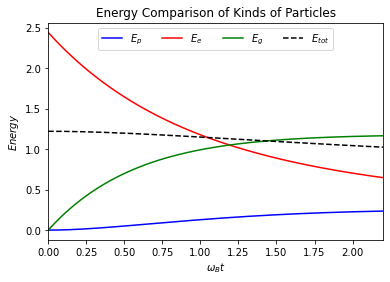

In [8]:
plt.plot(time_lst,enelst_final_p *0.9 *2.5 * 10**(-5),'blue', label=r'$E_{p}$')
plt.plot(time_lst,enelst_final_e* 0.9 *2.5 * 10**(-5),'red', label=r'$E_{e}$')
plt.plot(time_lst,enelst_final_g* 2.5 *0.9 * 10**(-5),'green', label=r'$E_{g}$')
plt.plot(time_lst,0.5*(enelst_final_g+enelst_final_e+enelst_final_p)*2.5 *0.9 * 10**(-5),'--k', label=r'$E_{tot}$')
plt.title('Energy Comparison of Kinds of Particles')
plt.xlabel(r'$\omega_B t$')
plt.ylabel(r'$Energy$')
plt.xlim(0, 2.2)
plt.legend(loc='upper center', ncol=4)
plt.show()

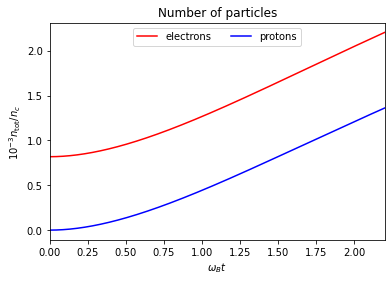

In [9]:
plt.plot(time_lst, numlst_final_e*1e3*0.9 *2.5 * 10**(-5),'red', label=r'electrons')
plt.plot(time_lst, numlst_final_p*1e3*0.9 *2.5 * 10**(-5),'blue', label=r'protons')
#plt.plot(time_lst, numlst_final_g*1e3*0.9 *2.5 * 10**(-5),'green')
plt.title('Number of particles')
plt.xlabel(r'$\omega_B t$')
plt.ylabel(r'$10^{-3} n_\mathrm{tot}/n_c$')
plt.xlim(0, 2.2)
plt.legend(loc='upper center', ncol=3)
plt.show()

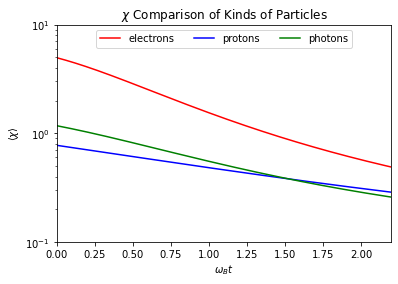

In [10]:
plt.plot(time_lst[1:],chilst_final_e[1:],'red', label=r'electrons')
plt.plot(time_lst[1:],chilst_final_p[1:],'blue', label=r'protons')
plt.plot(time_lst[1:],chilst_final_g[1:],'green', label=r'photons')
plt.title('$\chi$ Comparison of Kinds of Particles')
plt.xlim(0, 2.2)
plt.ylim(0.1, 10)
plt.yticks([0.1, 1, 10])
plt.xlabel(r'$\omega_B t$')
plt.ylabel(r'$\langle \chi \rangle$')
plt.yscale('log')
plt.legend(loc='upper center', ncol=3)
plt.show()